In [77]:
import pandas as pd
data = pd.read_csv('Eluvio_DS_Challenge.csv')

In [78]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

#used to show plots within the notebook
%matplotlib inline
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

#creation of a train test split of the data
sorted = data.sort_values(by = 'up_votes', ascending = False)
train, test = train_test_split(data, test_size=0.1, random_state=1)

In [79]:
#converting the date column of the dataframe to datetime objects in roder to plot the values on a graph
from datetime import datetime
df = train[['up_votes', 'date_created','title']]
df['date_created'] = [datetime.strptime(date_string, '%Y-%m-%d') for date_string in df.date_created]

<ipython-input-79-8b005347f94f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_created'] = [datetime.strptime(date_string, '%Y-%m-%d') for date_string in df.date_created]


<AxesSubplot:xlabel='date_created', ylabel='up_votes'>

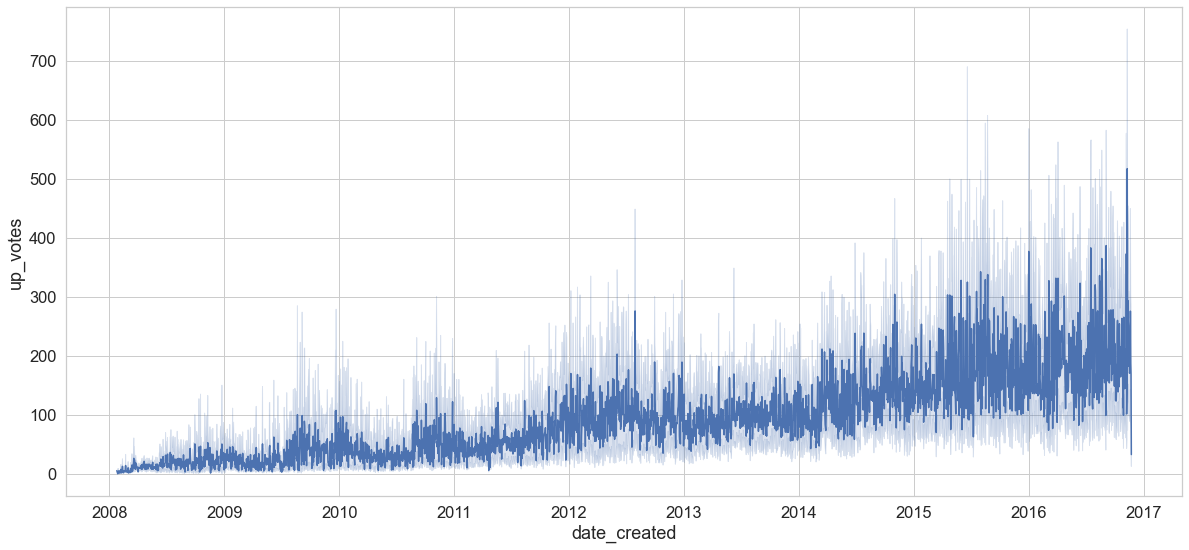

In [80]:
#plot of the date_created column to the up_votes column to check for obvious patterns
plt.figure(figsize=(20,9))
sns.lineplot(data=df, x='date_created', y='up_votes')

The data shows that up_votes per post generally trended upwards over the years, which makes sense as the userbase most likely grew. Could be used as a feature, although there's so much variance from the average that it may not be viable.

In [81]:
#create a new column specifically for the year in which the post was created
df['year'] = [date.year for date in df.date_created]

<ipython-input-81-8fdd1196b2cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = [date.year for date in df.date_created]


In [82]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

#identify the most common words used in titles each year, filter out common words using stopwords and also some words that are
#clearly common and/or not useful. The total word count is divided by the amount of posts made that year
stop = stopwords.words('english')
stop += ['The', 'says', 'In', 'It', 'said']
def top_words(df, year):
    word_count_list = {}
    yeardf = df[df['year'] == year]
    for title in yeardf['title']:
        words = re.findall('\w+', title)
        for word in words:
            if word in stop:
                continue
            word_count_list[word] = (word_count_list[word]+1) if word in word_count_list else 1
    return word_count_list

years = df['year'].unique()
years.sort()
top_words_year = {}
for year in years:
    posts_year = df[df['year'] == year].shape[0]
    year_words = (pd.Series(top_words(df, year)) / posts_year).sort_values(ascending=False)
    top_words_year[year] = year_words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


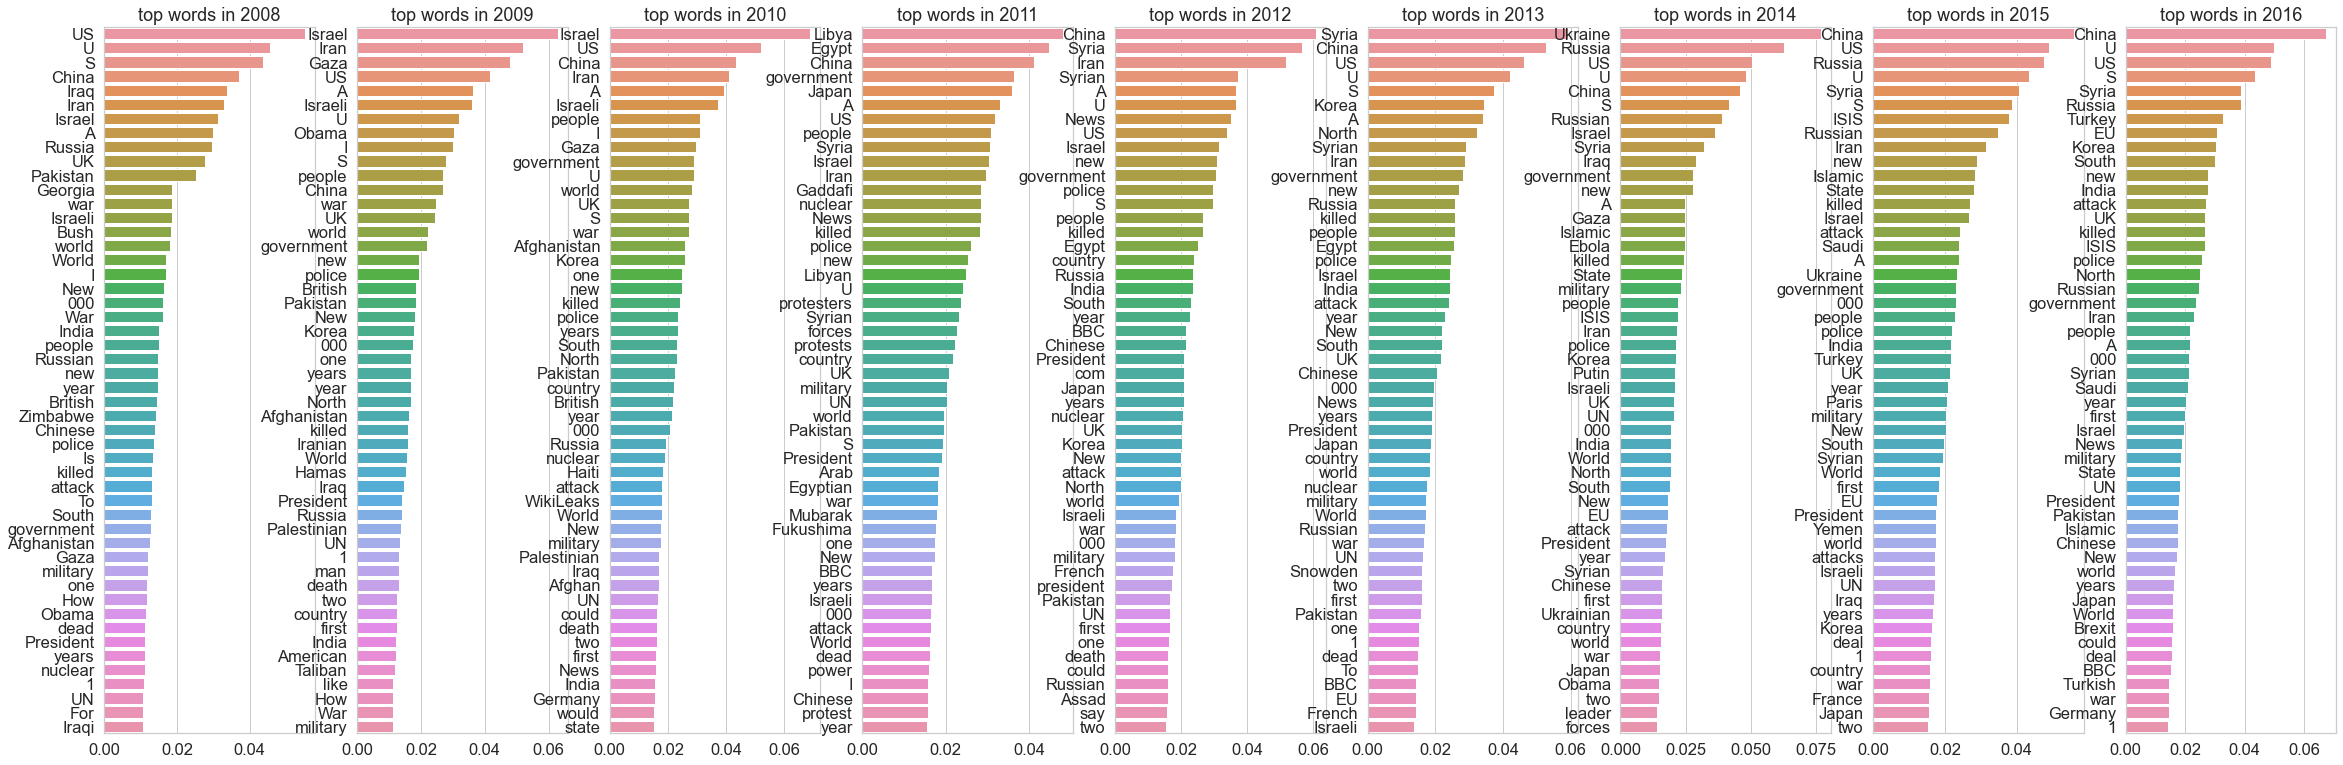

In [83]:
#plot of the most common words in a title by year
fig, axs = plt.subplots(ncols=len(years), figsize=(40,13))
counter = 0
for year in years:
    bar = sns.barplot(x=top_words_year[year].head(50).values, y=top_words_year[year].head(50).index, ax=axs[counter])
    counter += 1
    bar.set_title("top words in " + str(year))

Although some words are common throughout the years, such as "US" and "China", there are clearly unique words that are more frequently used due to major events occurring during the year. For instance, "Haiti" being a common word in 2010 is almost definitely due to the earthquake during that year. Some further analysis of popularity of certain titles using the "up_votes" category may be useful for the classifier as well. However, there are definitely words that I can identify to be used within the classifier.

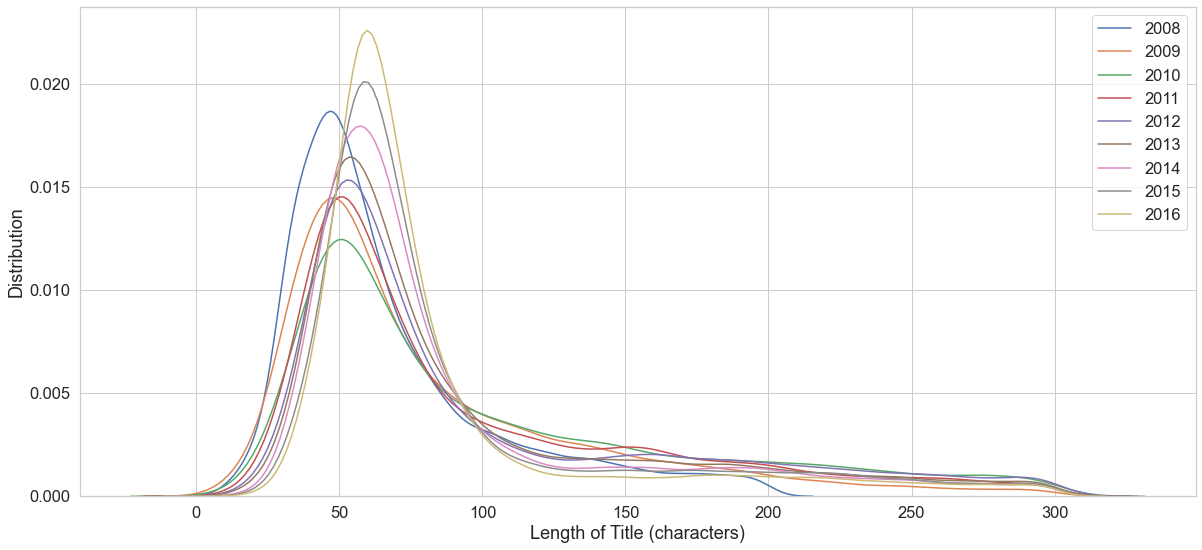

In [84]:
#checking if length of a title changes by year
fig, axs = plt.subplots(figsize=(20,9))
for year in years:
    lengths = [len(title) for title in df[df['year'] == year]['title']]
    sns.kdeplot(lengths, label=year, ax=axs)
    plt.ylabel('Distribution')
    plt.xlabel('Length of Title (characters)')
plt.legend()

While there are some trends over the years, such as titles around 60-70 characters becoming more and more common, there isn't a significant enough correlation of lengths of titles between years for the length to be used as a feature for a classifier.

In [85]:
df = df.sort_values(by='up_votes', ascending=False)
percentlen = int(df.shape[0] * .01)
temp = df['up_votes'].reset_index(drop=True)
cutoff = temp.loc[percentlen]
df['is_popular'] = [up_votes > cutoff for up_votes in df['up_votes']]

popular_list = {}
tempdf = df[df['is_popular'] == True]
for title in tempdf['title']:
    words = re.findall('\w+', title)
    for word in words:
#        if word in stop:
#                continue
        popular_list[word] = (popular_list[word]+1) if word in popular_list else 1

unpopular_list = {}
tempdf = df[df['is_popular'] == False]
for title in tempdf['title']:
    words = re.findall('\w+', title)
    for word in words:
 #       if word in stop:
 #               continue
        unpopular_list[word] = (unpopular_list[word]+1) if word in unpopular_list else 1

popular_words = pd.Series(popular_list) / percentlen
unpopular_words = pd.Series(unpopular_list) / int(df.shape[0] * .99)

Text(0.5, 1.0, 'top unpopular words')

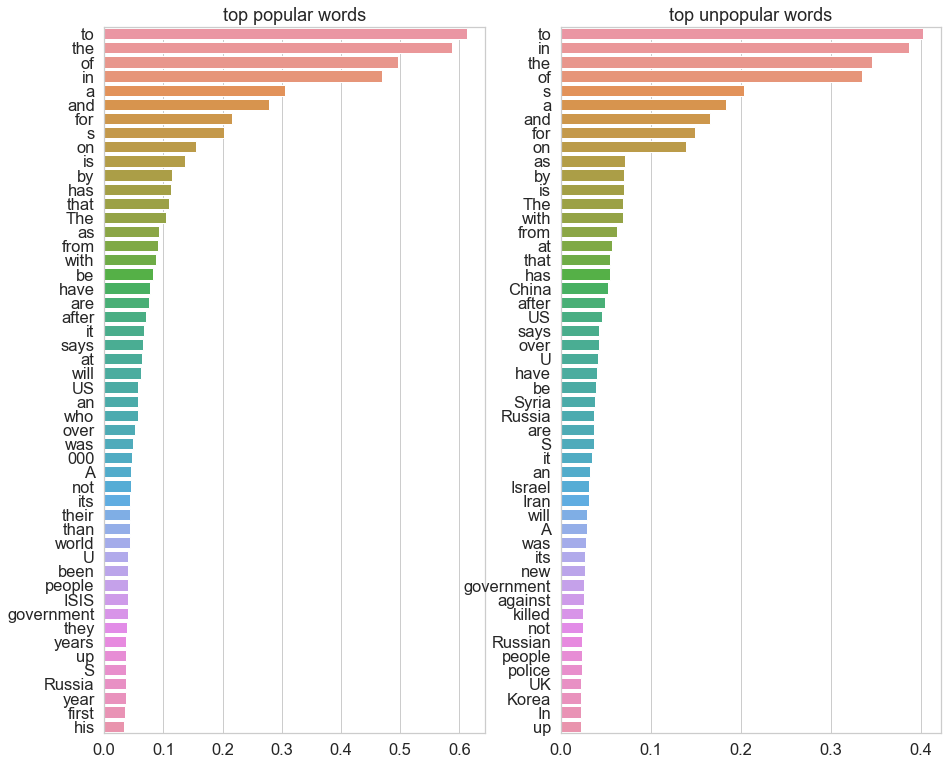

In [86]:
popular_words = popular_words.sort_values(ascending=False)
unpopular_words = unpopular_words.sort_values(ascending=False)

fig, axs = plt.subplots(ncols=2, figsize=(15,13))
pop_bar = sns.barplot(x=popular_words.head(50).values, y=popular_words.head(50).index, ax=axs[0])
pop_bar.set_title('top popular words')
unpop_bar = sns.barplot(x=unpopular_words.head(50).values, y=unpopular_words.head(50).index, ax=axs[1])
unpop_bar.set_title('top unpopular words')

I chose to leave stop words within this comparison because I believed that there was a chance that the selection of stop words used may have had an impact on the popularity of the post. There was a large amount of overlap between the words, however, so I decided to remove duplicates between the sets of words in the next section.

In [87]:
hundredpop = popular_words.head(300)
hundredunpop = unpopular_words.head(300)

popular_indices = hundredpop.index
unpopular_indices = hundredunpop.index

for index in unpopular_indices:
    if index in hundredpop.index:
        hundredpop = hundredpop.drop(index)

for index in popular_indices:
    if index in hundredunpop.index:
        hundredunpop = hundredunpop.drop(index)

hundredpop

Snowden     0.023784
NSA         0.017674
We          0.017674
should      0.015492
public      0.015274
              ...   
get         0.008073
month       0.008073
Internet    0.008073
An          0.008073
11          0.008073
Length: 80, dtype: float64

In [88]:
#function for checking if a word exists within a title
def word_in_title(words, titles):
    matrix = [[word in title for word in words] for title in titles]
    return matrix

In [91]:
#processes the data into a matrix to feed into the logistic regressor model, uses the important words as a feature as most of the other things I attempted didn't appear useful
def process_data_set(df):
    some_words = hundredpop.index
    X_train = np.array(word_in_title(some_words, df['title'])).astype(int)
    return X_train

X_train = process_data_set(df)
Y_train = df['is_popular']

In [90]:
#fits a logistic regression model on the training data and features
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
training_acc = model.score(X_train, Y_train)
print(training_acc)

0.9900002618303688


In [74]:
#checks how the model performs with the test data
test = test.sort_values(by='up_votes', ascending=False)
percentlen = int(test.shape[0] * .01)
temp = test['up_votes'].reset_index(drop=True)
cutoff = temp.loc[percentlen]
test['is_popular'] = [up_votes > cutoff for up_votes in test['up_votes']]

X_test = process_data_set(test)
Y_test = test['is_popular']
test_acc = model.score(X_test, Y_test)
test_acc

0.9900047129055063

The model overall was fairly accurate at predicting whether a post would be "popular"- meaning that it ranked within the top 1% of the posts within the dataset. I ran several different seeds to check for any obvious examples of overfitting, but didn't find anything significant. Originally, I planned to attempt to classify what year a post would be found in, but found some difficulty in finding effective features for implementing it, and eventually came to the conclusion that checking if a post would be successful or not would be a more useful model as well as one in which I had very clear ideas on how to implement. There were also some other aspects of the data that were somewhat strange to me as well, such as the lack of information within the "down_votes" and "category" columns, but overall I believe that I was able to create a fairly effective model for what I wanted to accomplish.